In [164]:
from IPython.display import HTML, Image, display
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()">
<input type="submit" value="Click to toggle on/off the raw code.">
</form>''')

# Halo-Halo! Predicting Concrete Compressive Strength using Mix Proportions

Concrete is the most widely used construction material in the world. This can be attributed to the ubiquity of the four basic materials needed to create it along with its low cost.[1]

In this study, we aim to predict concrete compressive strength using the composition mix.

## Highlights

1. Concrete compressive strength is non-linear because linear models perform poorly when it is fitted.

2. For the full dataset, the best model is Random Forest with an $R^2$ of 0.9205 and `age` as the top predictor.

3. For the `age >= 28`, the best model is Random Forest with an $R^2$ of 0.9049 for the full dataset and `wc_ratio` as the top predictor.

4. A distinction was made between the inclusion of partially cured concrete due to different use cases.

5. Implementation uses `GridSearchCV`, `RepeatedKFold` and `Pipeline` from the scikit-learn library not discussed in class.

## Exploratory Data Analytics

In [135]:
# utility libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# scaling
from sklearn.preprocessing import StandardScaler

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.pipeline import Pipeline

# regressor models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [67]:
plt.rcParams["figure.figsize"] = (15,6)

### Load Data

The public dataset is from Prof. I-Cheng Yeh. In 1998, he conducted a study on this concrete compressive strength using  artifical neural networks.[3] The dataset is also readily accessible on the UCI Machine Learning Repository: http://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength.

The following are the variables in the dataset:

| Variable | Description | Units |
| --- | --- | --- |
| Cement | concrete binder | kg/m<sup>3 |
| Blast Furnace Slag | by-product from iron production | kg/m<sup>3 |
| Fly Ash | fine residue from combustion of pulverized coal | kg/m<sup>3 |
| Water | water added to concrete mix | kg/m<sup>3 |
| Superplasticizer | additive in high strength concrete | kg/m<sup>3 |
| Coarse Aggregate | gravel or crushed stone greater than 3/8-inch diameter | kg/m<sup>3 |
| Fine Aggregate | sand or crushed stone of 3/8-inch diameter | kg/m<sup>3 |
| Age | number of days of curing upon testing | days |
| Compressive Strength | Concrete compressive strength | csMPa |

Concrete Compressive Strength is continuous so we will use regression. The main ingredients of concrete are `cement`, `water`, `coarse aggregates`, and `fine aggregates`.

`blast furnace slae`, `fly ash` and `superplasticizer` are known as admixtures. They add to properties of concrete.

`age` is the number of days of curing upon testing. This is an important factor because concrete only reaches full compressive strength at 28 days. That means for less than 28 days we expect concrete it to have lower amount of compressive strength and higher variability due to possible addition of admixtures. [2]

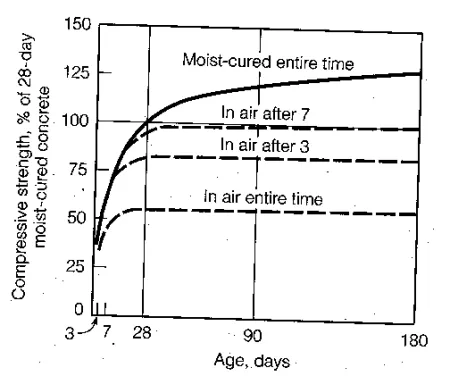

In [114]:
Image('effect-of-age-on-strength.png')

In [119]:
# load the dataset
data = pd.read_csv('Concrete_Data_Yeh.csv')
display(data.head())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [97]:
# check dtypes for any categorical variables
display(data.dtypes)

cement              float64
slag                float64
flyash              float64
water               float64
superplasticizer    float64
coarseaggregate     float64
fineaggregate       float64
age                   int64
csMPa               float64
dtype: object

There are no categorical variables thus one hot encoding or oridnal-value encoding is not needed.

In [99]:
# checking for any null values
display(data.isnull().sum())

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

There is also no null values. There is no need to impute or delete rows. This dataset is relatively clean.

In [101]:
# checking for any differences in scale
display(data.describe())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


The units of the values are all in $kg/m^3$ except for age. Values are relatively within scale of each other. Scaling is not required in this case. It is still done anyway and included in the pipeline.

In [109]:
# checking variance before and after 28 days.
display(data.groupby(data['age'] >= 28).var())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
age,,,,,,,,,
False,10837.107282,7784.523629,3774.158379,373.270371,39.049291,5347.120894,5991.601305,16.142071,154.037872
True,10922.789294,7266.744988,4216.741462,488.317850,33.837761,6197.622955,6544.940566,4796.407619,235.713294


Variance of some features changes before and after 28 days.

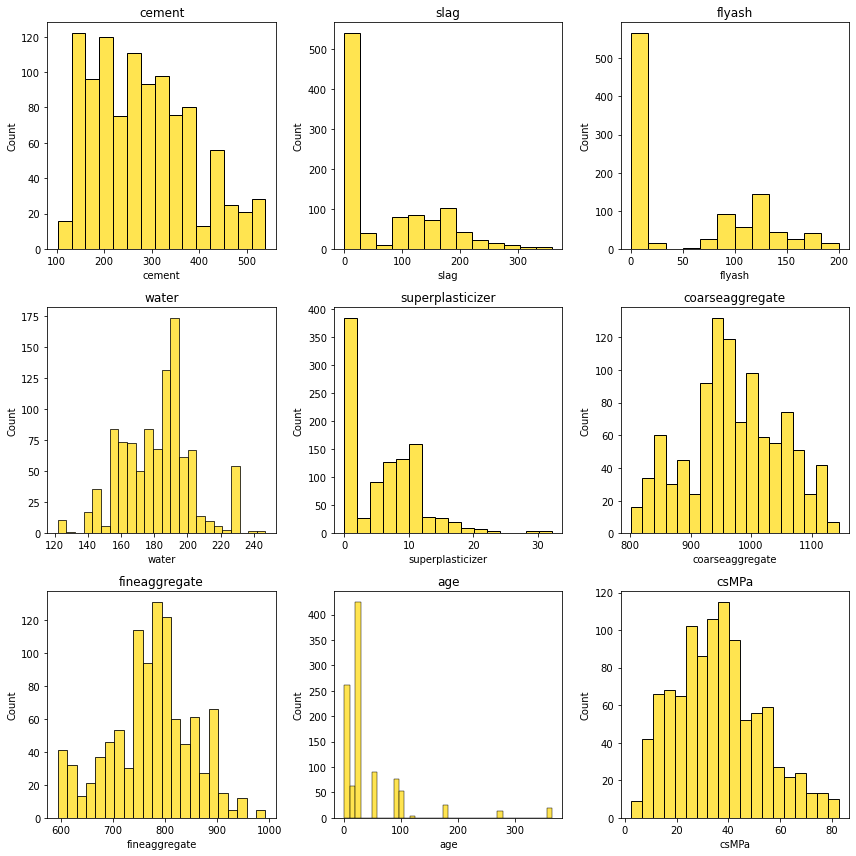

In [57]:
# distribution of features
col_nums = 3
row_nums = 3
plt.figure(figsize=(12, 12))
for i, (k, v) in enumerate(data.items(), 1):
    plt.subplot(row_nums, col_nums, i)
    p = sns.histplot(data=v, color='#ffdb15')
    plt.title(k)
plt.tight_layout()
plt.show()

The distributions look okay to work with, with the exception of age which seems sparse with only a few unique values.

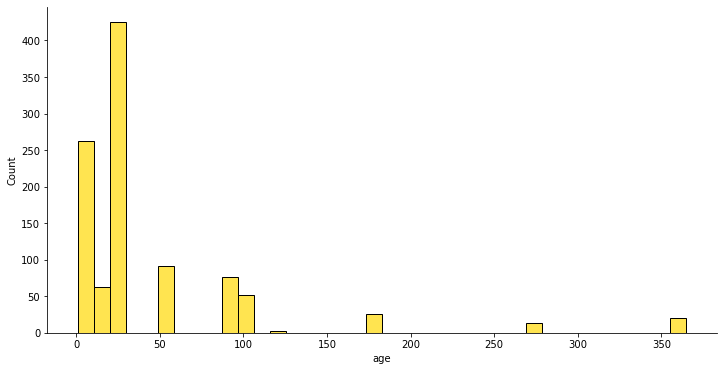

In [62]:
fig, ax = plt.subplots()
sns.histplot(data=data['age'], color='#ffdb15')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Zooming in, we see the values of `age` only occurs at certain values.

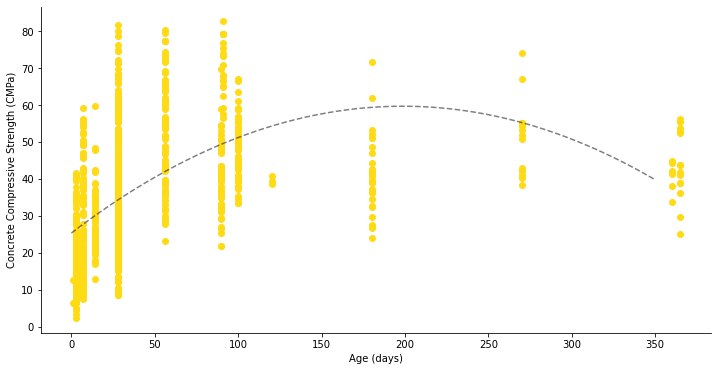

In [56]:
plt.rcParams['figure.figsize'] = (12, 6)

b2, b1, b0 = np.polyfit(x=data['age'], y=data['csMPa'], deg=2)
X = np.arange(0, 351)
y = b2*X**2 + b1*X + b0

fig, ax = plt.subplots()
ax.scatter(x=data['age'], y=data['csMPa'], c='#ffdb15')
ax.plot(y, 'k--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Concrete Compressive Strength (CMPa)')
ax.set_xlabel('Age (days)')
plt.show()

Age and concrete compressive strength are not linear. It seems to follow a parabolic trendline. Compared to the graph above we see that concrete at early values of `age` actually follows an empirical curve. Sometimes before achieving full compressive strength, it is actually modeled as linear.

## Results and Discussions

### Model Selection

In [144]:
# assign features and target
y_1 = data['csMPa']
X_1 = data.drop('csMPa', axis=1)

# save feature names
feature_names = X_1.columns

In [125]:
cols = ['mean_test_score', 'params']
res_cols = ['Test Score', 'Best Parameter', 'Top Predictor', 'Time']
idx = ['kNN', 'Linear Regression (L1)', 'Linear Regression (L2)',
       'LinearSVR', 'Random Forest', 'Gradient Boosting Method']
def reg_knn(X, y):
    start_time = time.time()
    
    # hyperparameters
    n = range(1, 21)
    params = {'knn__n_neighbors': n}
    
    # cross-validation settings
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)

    # scaler and model
    scaler = ('scaler', StandardScaler())
    model = ('knn', KNeighborsRegressor())
    pipeline = Pipeline([scaler, model])

    # gridsearch
    cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=rkf,
                      return_train_score=True, scoring='r2').fit(X, y)
    res = pd.DataFrame(cv.cv_results_, columns=cols)
    res = res.loc[cv.best_index_]
    res['Top Predictor'] = None
    res['time'] = (time.time() - start_time)
    return res.values

def reg_linear(model, X, y):
    start_time = time.time()

    # hyperparameters
    alpha_range = [1e-6, 1e-5, 1e-4, 1e-3, 0.10, 0.25, 0.5, 0.75,
               1, 1.5, 3, 5, 10, 15, 20, 100, 250, 1000, 5000]
    if model[0] == 'LinearSVR':
        params = {model[0]+'__C': alpha_range}
    else:
        params = {model[0]+'__alpha': alpha_range}

    # cross-validation settings
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)

    # scaler
    scaler = ('scaler', StandardScaler())
    pipeline = Pipeline([scaler, model])

    # gridsearch
    cv = GridSearchCV(estimator=pipeline, param_grid=params, cv=rkf,
                      return_train_score=True, scoring='r2').fit(X, y)
    res = pd.DataFrame(cv.cv_results_, columns=cols)
    res = res.loc[cv.best_index_]
    res['Top Predictor'] = feature_names[(cv.best_estimator_.steps[1][1]
                                          .coef_.argmax())]
    res['time'] = (time.time() - start_time)
    return res.values

def reg_tree(model, X, y):
    start_time = time.time()

    # hyperparameters
    features_tuning = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0]
    params = {'max_features': features_tuning}

    # cross-validation settings
    rkf = RepeatedKFold(n_splits=5, n_repeats=10)

    # gridsearch
    cv = GridSearchCV(estimator=model, param_grid=params, cv=rkf,
                      return_train_score=True, scoring='r2').fit(X, y)
    res = pd.DataFrame(cv.cv_results_, columns=cols)
    res = res.loc[cv.best_index_]
    res['Top Predictor'] = feature_names[(cv.best_estimator_.
                                          feature_importances_.argmax())]
    res['time'] = (time.time() - start_time)
    return res.values

**Attempt 1.**

The linear models perform poorly because age is an important nonlinear factor.

Standard scaling is applied except in ensemble models. The current set parameters for Repeated K Fold cross validation is `n_splits=5`, `n_repeats=10`. Since regression is used, the test score is set to be $R^2$. The `best_estimator` or the best parameter in the table is determined by `GridSearchCV` as the estimator with combination of parameters with the highest test score.

Top predictors for linear models is `cement` and `age` for the ensemble models which perform the best.

In [132]:
results_1 = pd.DataFrame([
    reg_knn(X_1, y_1),
    reg_linear(('L1', Lasso(max_iter=1e7)), X_1, y_1),
    reg_linear(('L2', Ridge()), X_1, y_1),
    reg_linear(('LinearSVR', LinearSVR(max_iter=1e6)), X_1, y_1),
    reg_tree(RandomForestRegressor(), X_1, y_1),
    reg_tree(GradientBoostingRegressor(), X_1, y_1),
        ], columns=res_cols, index=idx)
display(results_1)

,Test Score,Best Parameter,Top Predictor,Time
kNN,0.718328,{'knn__n_neighbors': 4},None,18.992944
Linear Regression (L1),0.602386,{'L1__alpha': 0.001},cement,8.375763
Linear Regression (L2),0.601064,{'L2__alpha': 1},cement,8.161961
LinearSVR,0.581101,{'LinearSVR__C': 0.5},cement,70.098527
Random Forest,0.913143,{'max_features': 0.5},age,113.773968
Gradient Boosting Method,0.904799,{'max_features': 0.4},age,36.617184


**Attempt 2.**
It is best to try to run the model _without_ `age` < 28 data.

In [130]:
# assign features and target
y_2 = data[data.age >= 28]['csMPa']
X_2 = data[data.age >= 28].drop('csMPa', axis=1)

# save feature names
feature_names = X_2.columns

In [133]:
results_2 = pd.DataFrame([
    reg_knn(X_2, y_2),
    reg_linear(('L1', Lasso(max_iter=1e7)), X_2, y_2),
    reg_linear(('L2', Ridge()), X_2, y_2),
    reg_linear(('LinearSVR', LinearSVR(max_iter=1e6)), X_2, y_2),
    reg_tree(RandomForestRegressor(), X_2, y_2),
    reg_tree(GradientBoostingRegressor(), X_2, y_2),
        ], columns=res_cols, index=idx)
display(results_2)

,Test Score,Best Parameter,Top Predictor,Time
kNN,0.720621,{'knn__n_neighbors': 3},None,19.135961
Linear Regression (L1),0.718178,{'L1__alpha': 0.001},cement,8.512517
Linear Regression (L2),0.717436,{'L2__alpha': 0.25},cement,8.317084
LinearSVR,0.698067,{'LinearSVR__C': 5},cement,59.476540
Random Forest,0.896206,{'max_features': 0.8},cement,93.278874
Gradient Boosting Method,0.891208,{'max_features': 0.8},cement,31.330868


We see an improvement for the linear models but reduced score for the ensemble models.

`cement` is now the top predictor across all models.

### Feature Engineering

We can now apply feature engineering to generate important features as defined by domain knowledge.

In this case, we have three new features[CITATION]:
1. Water-Cement Ratio.

The ratio of water and cement in the mix.

2. Aggregate-Cement Ratio.

The ratio of the sum of coarse and fine aggregate and cement in the mix.

3. Aggregate Proportion.

The ratio of the sum of coarse and fine aggregate and the total weight/density of the mix.


In [149]:
X_3 = data.copy()
X_3["total_density"] = X_3[['cement', 'slag', 'flyash', 'water',
                            'superplasticizer', 'coarseaggregate',
                            'fineaggregate']].sum(axis=1)
X_3['wc_ratio'] = X_3['water'] / X_3['cement']
X_3['ac_ratio'] = ((X_3['coarseaggregate'] + X_3['fineaggregate']) / 
                   X_3['cement'])
X_3['agg_proportion'] = ((X_3['coarseaggregate'] + X_3['fineaggregate']) /
                         X_3['total_density'])
X_3 = X_3.drop(['total_density', 'csMPa'], axis=1)
feature_names = X_3.columns
display(X_3.head())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,wc_ratio,ac_ratio,agg_proportion
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,0.300000,3.177778,0.708944
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,0.300000,3.205556,0.710737
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,0.685714,4.589474,0.684612
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,0.685714,4.589474,0.684612
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,0.966767,9.083082,0.775237


We add the new columns for water-cement ratio, aggregate ratio and aggregate proportion and apply it for the models.

In [150]:
results_3 = pd.DataFrame([
    reg_knn(X_3, y_1),
    reg_linear(('L1', Lasso(max_iter=1e7)), X_3, y_1),
    reg_linear(('L2', Ridge()), X_3, y_1),
    reg_linear(('LinearSVR', LinearSVR(max_iter=1e6)), X_3, y_1),
    reg_tree(RandomForestRegressor(), X_3, y_1),
    reg_tree(GradientBoostingRegressor(), X_3, y_1),
        ], columns=res_cols, index=idx)
display(results_3)

,Test Score,Best Parameter,Top Predictor,Time
kNN,0.703075,{'knn__n_neighbors': 3},None,23.498396
Linear Regression (L1),0.603664,{'L1__alpha': 0.001},age,51.826210
Linear Regression (L2),0.602626,{'L2__alpha': 5},age,9.262298
LinearSVR,0.589274,{'LinearSVR__C': 0.5},age,136.105182
Random Forest,0.920545,{'max_features': 0.7},age,141.408117
Gradient Boosting Method,0.913636,{'max_features': 0.5},age,51.552865


**Attempt 3.**

Random Forest is the best model to use for our data. `age` is now the top predictor for all variables. This can be attributed to cement being present in the new variables which reduces its feature importance.

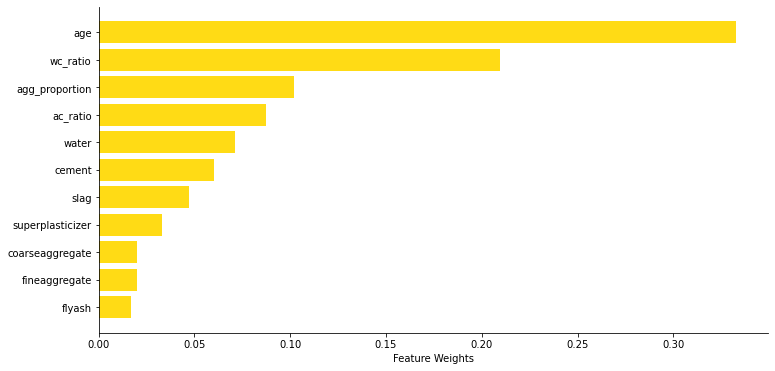

In [157]:
start_time = time.time()

# hyperparameters
features_tuning = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0]
params = {'max_features': features_tuning}

# cross-validation settings
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# gridsearch
cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, cv=rkf,
                  return_train_score=True, scoring='r2').fit(X_3, y_1)
idx = cv.best_estimator_.feature_importances_.argsort()
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
ax.barh(feature_names[idx], sorted(cv.best_estimator_.feature_importances_),
        color='#ffdb15')
ax.set_xlabel('Feature Weights')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

We can see that age is the top predictor and the feature-engineered columns are the next top predictors. This confirms that the new feature engineered values have more weight in compressive strength than the previous features when the full dataset is included.

In [158]:
X_4 = X_2.copy()
X_4["total_density"] = X_4[['cement', 'slag', 'flyash', 'water',
                            'superplasticizer', 'coarseaggregate',
                            'fineaggregate']].sum(axis=1)
X_4['wc_ratio'] = X_4['water'] / X_4['cement']
X_4['ac_ratio'] = ((X_4['coarseaggregate'] + X_4['fineaggregate']) / 
                   X_4['cement'])
X_4['agg_proportion'] = ((X_4['coarseaggregate'] + X_4['fineaggregate']) /
                         X_4['total_density'])
X_4 = X_4.drop('total_density', axis=1)
feature_names = X_4.columns
display(X_4.head())

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,wc_ratio,ac_ratio,agg_proportion
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,0.300000,3.177778,0.708944
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,0.300000,3.205556,0.710737
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,0.685714,4.589474,0.684612
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,0.685714,4.589474,0.684612
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,0.966767,9.083082,0.775237


Now we try this again but only using fully cured (age > 28) concrete. Again, we add the engineered features to the data.

In [162]:
idx = ['kNN', 'Linear Regression (L1)', 'Linear Regression (L2)',
       'LinearSVR', 'Random Forest', 'Gradient Boosting Method']
results_4 = pd.DataFrame([
    reg_knn(X_4, y_2),
    reg_linear(('L1', Lasso(max_iter=1e6, tol=0.01)), X_4, y_2),
    reg_linear(('L2', Ridge()), X_4, y_2),
    reg_linear(('LinearSVR', LinearSVR(max_iter=1e6)), X_4, y_2),
    reg_tree(RandomForestRegressor(), X_4, y_2),
    reg_tree(GradientBoostingRegressor(), X_4, y_2),
        ], columns=res_cols, index=idx)
display(results_4)

,Test Score,Best Parameter,Top Predictor,Time
kNN,0.845928,{'knn__n_neighbors': 2},None,18.700732
Linear Regression (L1),0.726424,{'L1__alpha': 0.001},fineaggregate,28.959966
Linear Regression (L2),0.727696,{'L2__alpha': 1.5},fineaggregate,9.333157
LinearSVR,0.710463,{'LinearSVR__C': 15},slag,114.501502
Random Forest,0.904860,{'max_features': 0.8},wc_ratio,112.594338
Gradient Boosting Method,0.900885,{'max_features': 0.5},wc_ratio,43.732938


**Attempt 4.**

We see that the best model to use is still Random Forest with a score better than the one without engineered features. However, we see now that water-cement ratio is the top predictor rather than age.

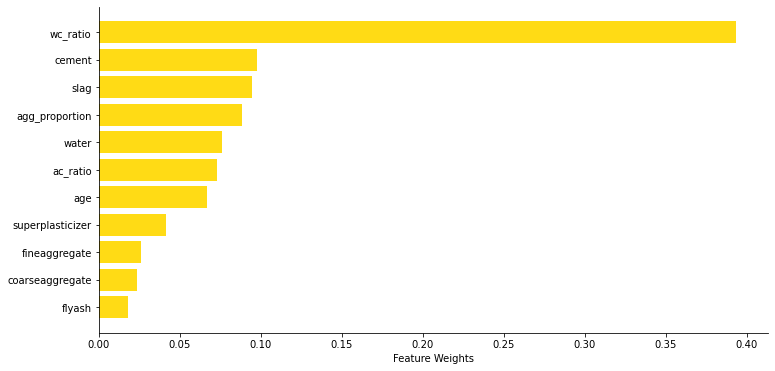

In [163]:
start_time = time.time()

# hyperparameters
features_tuning = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8, 0.9, 1.0]
params = {'max_features': features_tuning}

# cross-validation settings
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# gridsearch
cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, cv=rkf,
                    return_train_score=True, scoring='r2').fit(X_4, y_2)
idx = cv.best_estimator_.feature_importances_.argsort()

plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()
ax.barh(feature_names[idx], sorted(cv.best_estimator_.feature_importances_),
        color='#ffdb15')
ax.set_xlabel('Feature Weights')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In this case, we can clearly see how much `wc-ratio` dominates in terms of weight compared to the other features.

## Conclusions

1. The use of engineered features is necessary and improves our models. These are also determined through domain expertise which means the value is empirical and has been determined through practice.


2. If the use case calls for determining the fastest time to reach a certain compressive strength along with mix proportion, we can use  Random Forest for the whole dataset including `age` and add teh engineered features as well. This is  still appropriate for the main problem statement as curing time is still an important factor in the real world and cannot simply be dropped.


3. If use case only calls for determining the propoer mixes, regardless of age, then the Random Forest model using only age > 28 should be used with engineered features. In construction, 28 days curing period is still the industry standard set. This means, that time is readily alloted for concrete to cure thus using the age > 28 dataset will be more appropriate if that standard is in place. This gives the top predictor as water-cement ratio. In the industry, water-cement ratio is known to influence these factors of concrete:
        Strength
        Workability
        Durability
        Hydration
        Binding
        Compaction
        Mixing
        Transportation
        Corrosion
        Porosity
        Permeability
        Carbonation
        Freeze-Thaw Effect


4. The use of sklearn classes such as `Pipeline`, `RepeatedKFolds` and `GridSearchCV` make hyperparameter tuning easier and more organized. The `Pipeline`  class specifically has been extremely useful and allows for application of scaling after splitting which prevents bleed in of information into the test set for each split.

### Recommendations

1. The use of more engineered features is advisable given that they are based on recommnedations from experts.

2. It is recommended that other parameters for Random Forest and Gradient Boosting Method be applied.

3. It is recommended that Support Vector Machines also be used as they handle non linear data as well.

4. Using other types of scaling can also be explored such as `MinxMax`.

5. Multicollinearity checks with the engineered features can be applied as well.

## References

[1] PRASAD. (n.d.). _Key Factors Affecting Strength of Concrete._ Retrieved September 2021, from Structural Guide: https://www.structuralguide.com/factors-affecting-strength-of-concrete/

[2] The Constructor. (n.d.). _Concrete Compressive Strength Variation with Time._ Retrieved September 2021, from The Concstructor: https://theconstructor.org/concrete/concrete-compressive-strength-variation-with-time/5933/

[3] Yeh, I.-C. (1998, December). _Modeling of Strength of High-Performance Concrete Using Artificial Neural Networks._ Cement and Concrete Research, 28(12), 1797-1808.